In [8]:
%matplotlib inline
%reset -f
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [ ]:
# (re-)load layers
%run modules.ipynb

D:\Projects\ml-course\homeworks\hw07_nn_from_scratch\modules.py:432: SyntaxWarning: invalid escape sequence '\g'
  Implements linear transform of input y = \gamma * x + \beta


<Figure size 640x480 with 0 Axes>

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [10]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

Train, validation, test splits

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20000, random_state=1, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1, shuffle=True, stratify=y_test)

Defining a simple Fully-connected network

In [ ]:
net = Sequential()
net.add(Linear(784, 32))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(32))
net.add(ReLU())
net.add(Linear(32, 32))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(32))
net.add(ReLU())
net.add(Linear(32, 10))
net.add(LogSoftMax())

print(net)

loss_fn = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
# optimizer_config = {'learning_rate': 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 15
batch_size = 32

Linear 784 -> 32
BatchNormalization
ChannelwiseScaling
ReLU
Linear 32 -> 32
BatchNormalization
ChannelwiseScaling
ReLU
Linear 32 -> 10
LogSoftMax



In [30]:
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

def one_hot(vec, classes=10):

    to_int = np.vectorize(int)
    vec = to_int(vec)
    enc = np.eye(classes)[vec]
    return enc

Epoch 1
------------------------------
Train loss: 0.5278204262130793, Validation loss: 0.2913878479213727
Epoch 2
------------------------------
Train loss: 0.1817482641310736, Validation loss: 0.18517413638786606
Epoch 3
------------------------------
Train loss: 0.1483888187358028, Validation loss: 0.25372528587531457
Epoch 4
------------------------------
Train loss: 0.13014091463336297, Validation loss: 0.2408998548935412
Epoch 5
------------------------------
Train loss: 0.11844808646013955, Validation loss: 0.24410040451729342
Epoch 6
------------------------------
Train loss: 0.10934440165037433, Validation loss: 0.16849667782544436
Epoch 7
------------------------------
Train loss: 0.10127642037834339, Validation loss: 0.31905229794150125
Epoch 8
------------------------------
Train loss: 0.09735689748863861, Validation loss: 0.19380300771709888
Epoch 9
------------------------------
Train loss: 0.09200306504958938, Validation loss: 0.18158949849429715
Epoch 10
---------------

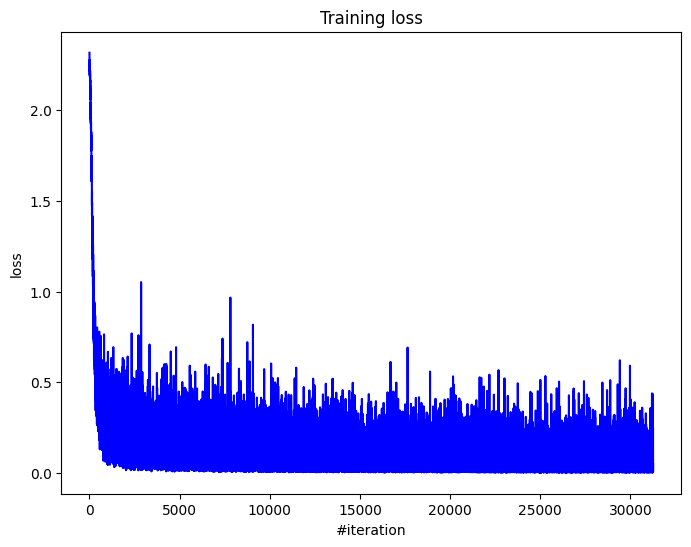

In [31]:
loss_history = []

for i in range(n_epoch):
    train_loss = []
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.train()
        net.zeroGradParameters()
        y_batch = one_hot(y_batch)
        
        # Forward
        predictions = net.forward(x_batch)
        loss = loss_fn.forward(predictions, y_batch)
    
        # Backward
        dp = loss_fn.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        train_loss.append(loss)

    val_loss = []
    for x_batch, y_batch in get_batches((X_val, y_val), batch_size):

        net.evaluate()
        y_batch = one_hot(y_batch)
        
        predictions = net.forward(x_batch)
        loss = loss_fn.forward(predictions, y_batch)

        val_loss.append(loss)

    
    # Stats
    train_loss = np.mean(train_loss)
    val_loss = np.mean(val_loss)
    print(f'Epoch {i + 1}\n------------------------------')
    print(f'Train loss: {train_loss}, Validation loss: {val_loss}')
    
plt.figure(figsize=(8, 6))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

In [32]:
def accuracy(y_pred, y_true):

    size = y_pred.shape[0]
    y_pred = np.argmax(y_pred, axis=1)
    acc = np.sum(y_pred == y_true) / size
    return acc

Print here your accuracy on test set. It should be around 90%.

In [33]:
acc = []
for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
    
    net.evaluate()
    y_batch = np.array(list(map(int, y_batch)))
    
    predictions = net.forward(x_batch)
    acc.append(accuracy(predictions, y_batch))

print(f'Test accuracy: {np.mean(acc)}')

Test accuracy: 0.9561701277955271
